In [32]:
from itertools import chain, combinations
from typing import Iterable, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from scipy import sparse

import networkx as nx

In [34]:
from utils import process_dataset
datasets = ['johnson8-2-4', 'johnson8-4-4', 'hamming6-2', 'hamming6-4']
edges = [210, 1855, 1824, 704]
Ns = []
hyperedges = []
complement_hyperedges = []
for dataset in datasets:
    n, hyperedge, complement_hyperedge = process_dataset(dataset, 4)
    Ns.append(n)
    hyperedges.append(len(hyperedge))
    complement_hyperedges.append(len(complement_hyperedge))

In [38]:
df_instances = pd.DataFrame({'Instance': datasets,
              'N': Ns,
              '2-graph edges': edges,
              '4-graph hyperedges': hyperedges,
              '4-graph complement hyperedges': complement_hyperedges})
print(df_instances.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & Instance & N & 2-graph edges & 4-graph hyperedges & 4-graph complement hyperedges \\
\midrule
0 & johnson8-2-4 & 28 & 210 & 10185 & 10290 \\
1 & johnson8-4-4 & 70 & 1855 & 800275 & 116620 \\
2 & hamming6-2 & 64 & 1824 & 630016 & 5360 \\
3 & hamming6-4 & 64 & 704 & 61776 & 573600 \\
\bottomrule
\end{tabular}



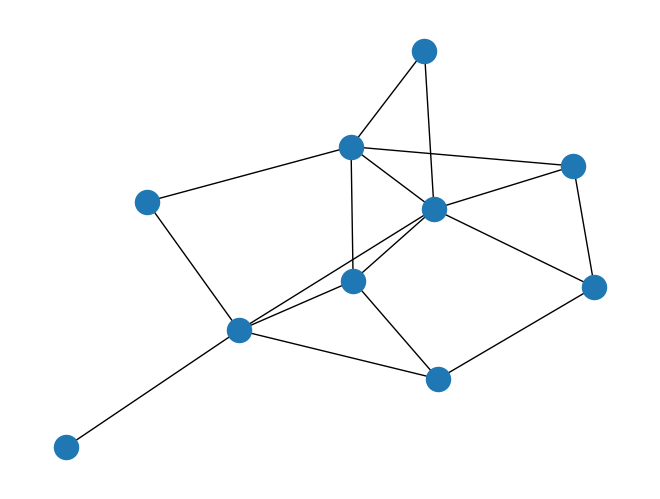

In [7]:
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p, seed=5, directed=False)
nx.draw(G)

In [8]:
existing_edges = []
for edge in G.edges():
    existing_edges.append(list(edge))

In [9]:
nx.complement(G).edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (1, 2), (1, 3), (1, 5), (1, 7), (1, 8), (2, 5), (2, 6), (2, 8), (3, 4), (3, 7), (4, 5), (4, 6), (4, 8), (4, 9), (5, 6), (5, 8), (5, 9), (6, 7), (6, 8), (7, 8)])

In [10]:
complement_edges = []
for comb in combinations(np.arange(n).tolist(), 2):
    if list(comb) in existing_edges:
        print(comb)
    else:
        complement_edges.append(list(comb))

(0, 7)
(1, 4)
(1, 6)
(1, 9)
(2, 3)
(2, 4)
(2, 7)
(2, 9)
(3, 5)
(3, 6)
(3, 8)
(3, 9)
(4, 7)
(5, 7)
(6, 9)
(7, 9)
(8, 9)


In [9]:
def LG(edges, x):
    results = 0
    for edge in edges:
        results += x[edge].prod()
    return results

def calc_obj_function(edges, x, tau):
    k = len(edges[0])
    LG_x = LG(edges, x)
    return LG_x + tau * (x ** k).sum()

def calc_gradient(edges, x, n, tau):
    gradient = np.zeros(n)
    for edge in edges:
        x_edge = x[edge]
        product = x_edge.prod()
        for i in range(len(edge)):
            node = edge[i]
            node_value = x_edge[i]
            if node_value != 0:
                gradient[node] += product / node_value
            else:
                remaining_nodes = edge[:i] + edge[i+1:]
                remaining_product = x[remaining_nodes].prod()
                gradient[node] += remaining_product
    k = len(edges[0])
    gradient += tau * k * (x ** (k - 1))
    return gradient

In [493]:
def calc_obj_function2(edges, x, tau):
    k = len(edges[0])
    LG = x[edges].prod(axis=1).sum()
    return LG + tau * (x ** k).sum()

In [529]:
def calc_gradient2(edges, x, n, tau):
    hg_matrix = x[edges]
    hg_indices = np.array(edges)
    k = hg_matrix.shape[1]
    e = hg_matrix.shape[0]
    remaining_products = np.zeros(hg_matrix.shape)
    for i in range(k):
        new_matrix = hg_matrix.copy()
        new_matrix[:,i] = np.ones(e)
        remaining_products[:,i] = new_matrix.prod(axis=1)
    grad = np.zeros(n)
    for i in range(n):
        grad[i] = remaining_products[hg_indices == i].sum()
    return grad + tau * k * (x ** (k - 1))

In [524]:
hg_indices = np.array(complement_edges)
remaining_products[hg_indices == 0]

array([0.11614624, 0.09788834, 0.08848864, 0.06880123, 0.10489274,
       0.07106385, 0.15649814, 0.06227063])

In [523]:
hg_matrix = x[complement_edges]
hg_indices = np.array(complement_edges)
k = hg_matrix.shape[1]
e = hg_matrix.shape[0]
n = 10
remaining_products = np.zeros(hg_matrix.shape)
for i in range(k):
    new_matrix = hg_matrix.copy()
    new_matrix[:,i] = np.ones(e)
    remaining_products[:,i] = new_matrix.prod(axis=1)
grad = np.zeros(n)
for i in range(n):
    grad[i] = remaining_products[hg_indices == i].sum()
grad

array([0.76604979, 0.68171806, 0.53772788, 0.41889768, 0.5723409 ,
       0.66179533, 0.66203065, 0.43219686, 0.6927426 , 0.26282089])

In [492]:
np.random.seed(0)
x = np.random.rand(n)
x = x / x.sum()

0.2901862318886209

In [527]:
calc_gradient(complement_edges, x, n, 0.55)

array([0.8640894 , 0.80947892, 0.64540505, 0.51623518, 0.64802226,
       0.77717735, 0.74020089, 0.59150248, 0.86489055, 0.33131858])

In [530]:
calc_gradient2(complement_edges, x, n, 0.55)

array([0.8640894 , 0.80947892, 0.64540505, 0.51623518, 0.64802226,
       0.77717735, 0.74020089, 0.59150248, 0.86489055, 0.33131858])

In [537]:
for _ in range(10**6):
    calc_gradient(complement_edges, x, 10, 0.5)

In [536]:
for _ in range(10**6):
    calc_gradient2(complement_edges, x, 10, 0.5)

In [91]:
x1 = np.zeros(n)
x1[0] = 1
grad = calc_gradient(complement_edges, x1, n, 0.55)
grad_argmin = grad.argmin()
s = np.zeros(n)
s[grad_argmin] = 1
d = s - x1
d

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [74]:
x1, x1 + d

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [124]:
gamma = 0.5
calc_obj_function(complement_edges, x1, 0.55), calc_obj_function(complement_edges, x1 + gamma * d, 0.55)

(0.55, 0.275)

In [127]:
a = np.array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1])
a = a / a.sum()
calc_obj_function(complement_edges, a, 0.51), calc_obj_function(complement_edges, x_k, 0.51)

(0.16999999999999998, 0.16949559775053893)

In [318]:
a = np.array([0.2  , 0.   , 0.075, 0.   , 0.125, 0.2  , 0.2  , 0.   , 0.2  , 0.   ])
calc_obj_function(existing_edges, a, 0.5)

0.1

In [319]:
a = np.array([0.2   , 0.2001, 0.1999, 0.    , 0.    , 0.2   , 0.    , 0.    , 0.2   , 0.    ])
calc_obj_function(existing_edges, a, 0.5)

0.10000001000000001

In [19]:
(x @ nx.adjacency_matrix(nx.complement(G)) @ x) / 2

0.24584104703871493

In [20]:
nx.adjacency_matrix(nx.complement(G)) @ x

array([0.70589106, 0.744212  , 0.36135886, 0.41849377, 0.54982639,
       0.61401219, 0.74004407, 0.26910513, 0.72079111, 0.33073973])

In [67]:
0.8 ** 2

0.6400000000000001

In [469]:
def frank_wolfe_random(edges, n, tau, max_iter = 10000, tol=1e-4, line_search='fixed_rule', seed=None):
    rng = np.random.default_rng(seed)
    x_k = rng.random(n)
    x_k = x_k / x_k.sum()
    #x_k = np.zeros(n)
    #x_k[7] = 1
    gamma = 1
    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        s = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        # print(grad_argmin)
        s[grad_argmin] = 1
        d = s - x_k
        duality_gap = grad @ d

        if line_search == 'fixed_rule':
            gamma = 2 / (2 + k)
            x_new = x_k + gamma * d
        elif line_search == 'armijo':
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.7
            m = 0
            #gamma = 1
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            ineq_left_side = of_old + 0.01 * gamma  * duality_gap
            while of_new > of_old + 0.1 * gamma  * duality_gap:
                print(gamma, of_new, ineq_left_side)
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 10000:
                    raise NotImplementedError('Bad Armijo')
        else:
            raise NotImplementedError("Unknown line search. Choose either fixed_rule or armijo.")
        x_k = x_new
        if duality_gap >= -tol:
            return x_k, k
    print('Maximum number of iterations reached')
    return x_k, k

In [538]:
def frank_wolfe(edges, n, tau, max_iter = 10000, tol=1e-4, line_search='fixed_rule', seed=None):
    #rng = np.random.default_rng(seed)
    #x_k = rng.random(n)
    #x_k = x_k / x_k.sum()
    x_k = np.zeros(n)
    x_k[0] = 1
    gamma = 1
    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        s = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        # print(grad_argmin)
        s[grad_argmin] = 1
        d = s - x_k
        duality_gap = grad @ d

        if line_search == 'fixed_rule':
            gamma = 2 / (2 + k)
            x_new = x_k + gamma * d
        elif line_search == 'armijo':
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.7
            m = 0
            #gamma = 1
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            ineq_left_side = of_old + 0.01 * gamma  * duality_gap
            while of_new > of_old + 0.1 * gamma  * duality_gap:
                print(gamma, of_new, ineq_left_side)
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 10000:
                    raise NotImplementedError('Bad Armijo')
        else:
            raise NotImplementedError("Unknown line search. Choose either fixed_rule or armijo.")
        x_k = x_new
        if duality_gap >= -tol:
            return x_k, k
    print('Maximum number of iterations reached')
    return x_k, k

In [465]:
x_k, k = frank_wolfe(complement_edges, n, 0.5, max_iter = 10000)
np.round(x_k, 4)

---------------------------------Iteration 0-----------------------------------
---------------------------------Iteration 1-----------------------------------
---------------------------------Iteration 2-----------------------------------
---------------------------------Iteration 3-----------------------------------
---------------------------------Iteration 4-----------------------------------
---------------------------------Iteration 5-----------------------------------
---------------------------------Iteration 6-----------------------------------
---------------------------------Iteration 7-----------------------------------
---------------------------------Iteration 8-----------------------------------
---------------------------------Iteration 9-----------------------------------
---------------------------------Iteration 10-----------------------------------
---------------------------------Iteration 11-----------------------------------
---------------------------------Itera

array([0.    , 0.3334, 0.    , 0.    , 0.    , 0.    , 0.3332, 0.    ,
       0.    , 0.3333])

In [540]:
x_k, k = frank_wolfe(complement_edges, n, 0.4, line_search='armijo', max_iter = 10000)
np.round(x_k, 3)

---------------------------------Iteration 0-----------------------------------
1 0.4 0.392
---------------------------------Iteration 1-----------------------------------
0.7 0.2672800000000001 0.230432
---------------------------------Iteration 2-----------------------------------
0.48999999999999994 0.22368646792000002 0.21563831984000006
---------------------------------Iteration 3-----------------------------------
0.3429999999999999 0.2116259012142354 0.20456527947026334
---------------------------------Iteration 4-----------------------------------
0.24009999999999992 0.20433410037721889 0.20285682245655337
---------------------------------Iteration 5-----------------------------------
0.16806999999999994 0.20254709047145858 0.2008335184454307
0.11764899999999995 0.20069817948648783 0.2008335184454307
---------------------------------Iteration 6-----------------------------------
0.08235429999999996 0.20078560712823004 0.20008477382929798
0.05764800999999997 0.20028031912447217 

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ])

In [545]:
sol = np.array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ])
sol_opt = np.array([0, 0. , 0.333333333333333 , 0.333333333333333 , 0. , 0. , 0. , 0, 0. , 0.333333333333333 ])
calc_obj_function2(complement_edges, sol, 0.5), calc_obj_function2(complement_edges, sol_opt, 0.5)

(0.25, 0.16666666666666632)

In [541]:
x_k, k = frank_wolfe(existing_edges, n, 0.5, max_iter = 10000, seed=4)
np.round(x_k, 4)

---------------------------------Iteration 0-----------------------------------
---------------------------------Iteration 1-----------------------------------
---------------------------------Iteration 2-----------------------------------
---------------------------------Iteration 3-----------------------------------
---------------------------------Iteration 4-----------------------------------
---------------------------------Iteration 5-----------------------------------
---------------------------------Iteration 6-----------------------------------
---------------------------------Iteration 7-----------------------------------
---------------------------------Iteration 8-----------------------------------
---------------------------------Iteration 9-----------------------------------
---------------------------------Iteration 10-----------------------------------
---------------------------------Iteration 11-----------------------------------
---------------------------------Itera

array([0.2001, 0.2   , 0.1999, 0.    , 0.    , 0.2   , 0.    , 0.    ,
       0.2   , 0.    ])

In [542]:
x_k, k = frank_wolfe(existing_edges, n, 0.5, max_iter = 10000, line_search='armijo')
np.round(x_k, 4), k

---------------------------------Iteration 0-----------------------------------
1 0.5 0.49
---------------------------------Iteration 1-----------------------------------
0.7 0.27109999999999995 0.28593999999999997
---------------------------------Iteration 2-----------------------------------
---------------------------------Iteration 3-----------------------------------
0.48999999999999994 0.16449955226278998 0.16921932583858
---------------------------------Iteration 4-----------------------------------
0.3429999999999999 0.1276099489046092 0.13185703090491216
---------------------------------Iteration 5-----------------------------------
0.24009999999999992 0.11166617891255612 0.11440906644729208
---------------------------------Iteration 6-----------------------------------
---------------------------------Iteration 7-----------------------------------
0.16806999999999994 0.10851094832705971 0.1021121879633504
0.11764899999999995 0.10404127924875467 0.1021121879633504
0.0823542999

(array([0.2   , 0.2   , 0.1999, 0.    , 0.    , 0.2001, 0.    , 0.    ,
        0.2   , 0.    ]),
 30)

In [135]:
calc_obj_function(complement_edges, x_k, 0.5)

0.16848751941575085

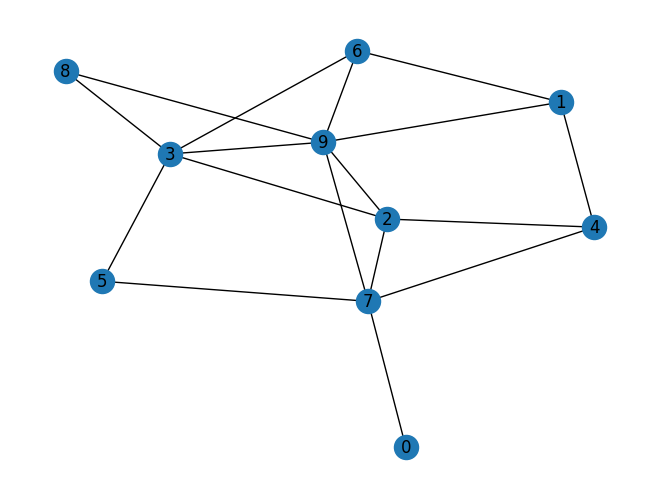

In [23]:
nx.draw(G, with_labels=True)

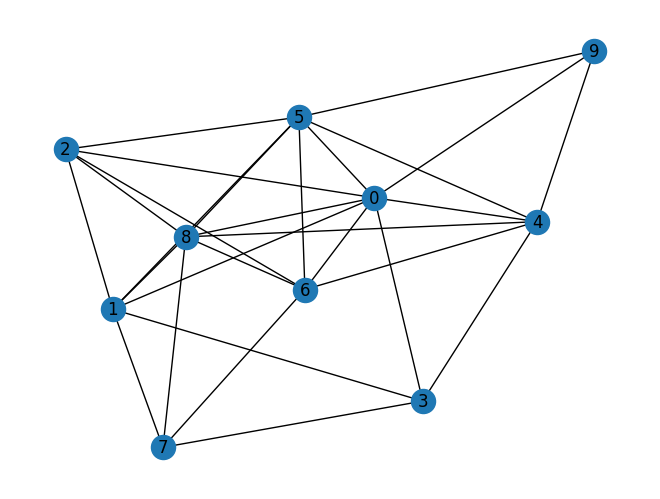

In [229]:
nx.draw(nx.complement(G), with_labels=True)

In [431]:
def pairwise_FW(edges, n, tau, max_iter = 10000, tol=1e-5, seed=None):
    # x_k = np.zeros(n)
    # x_k[3] = 1
    # alpha = np.zeros(n)
    # alpha[3] = 1
    # active_set = [3]
    rng = np.random.default_rng(seed)
    x_k = rng.random(n)
    x_k = x_k / x_k.sum()
    first_point = x_k.copy()
    active_set = []
    alpha = np.zeros(n+1)
    alpha[0] = 1

    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        print(f'x_k {x_k}')
        # solve LMO
        s = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        s[grad_argmin] = 1
        print(f's {s}')
        # find a maximizer over the active set
        if len(active_set) == 0:
            v = first_point
            alpha_index = 0
        else:
            grad_active_set = grad[active_set]
            grad_argmax_active = grad_active_set.argmax()
            if alpha[0] > 0:
                if (first_point @ grad) > grad_active_set[grad_argmax_active]:
                    v = first_point
                    alpha_index = 0
                else:
                    v = np.zeros(n)
                    v_index = active_set[grad_argmax_active]
                    v[v_index] = 1
                    alpha_index = v_index + 1
            else:
                v = np.zeros(n)
                v_index = active_set[grad_argmax_active]
                v[v_index] = 1
                alpha_index = v_index + 1
        # choose the direction
        d_fw = s - x_k
        duality_gap = grad @ d_fw
        print(duality_gap)
        if duality_gap >= -tol:
            return x_k, k
        d = s - v
        gamma_max = alpha[alpha_index]
        print(f'gamma max {gamma_max}')
        # armijo line search
        of_old = calc_obj_function(edges, x_k, tau)
        delta = 0.9
        m = 0
        gamma = gamma_max
        x_new = x_k + gamma * d
        of_new = calc_obj_function(edges, x_new, tau)
        ineq_left_side = of_old + tol * gamma  * duality_gap
        print(of_new, ineq_left_side)
        print(f'direction {d}')
        while of_new > ineq_left_side:
            m += 1
            gamma = (delta ** m) * gamma
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            print(f'of_new {of_new}')
            if m == 20:
                raise NotImplementedError('Bad armijo')
        print(f'm {m}')
        # set the new values of alpha and the active set
        alpha[alpha_index] = alpha[alpha_index] - gamma
        alpha[grad_argmin+1] = alpha[grad_argmin+1] + gamma
        print(f'alpha {alpha}')
        x_k = x_new
        active_set = np.where(alpha[1:] > 0)[0].tolist()

    print("Maximum number of iterations reached")
    return x_k, k

In [620]:
def pairwise_FW(edges, n, tau, max_iter = 10000, tol=1e-5, seed=None):
    # x_k = np.zeros(n)
    # x_k[3] = 1
    # alpha = np.zeros(n)
    # alpha[3] = 1
    # active_set = [3]
    rng = np.random.default_rng(seed)
    x_k = rng.random(n)
    x_k = x_k / x_k.sum()
    active_set = np.where(x_k > 0)[0].tolist()
    print(f"initial x: {x_k}")

    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        print(f'x_k {x_k}')
        # solve LMO
        s = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        s[grad_argmin] = 1
        print(f's {s}')
        # find a maximizer over the active set
        grad_active_set = grad[active_set]
        grad_argmax_active = grad_active_set.argmax()
        v = np.zeros(n)
        v_index = active_set[grad_argmax_active]
        v[v_index] = 1

        # choose the direction
        d_fw = s - x_k
        duality_gap = grad @ d_fw
        print(duality_gap)
        if duality_gap >= -tol:
            return x_k, k
        d = s - v
        gamma_max = x_k[v_index]
        print(f'gamma max {gamma_max}')
        # armijo line search
        of_old = calc_obj_function(edges, x_k, tau)
        delta = 0.9
        m = 0
        gamma = gamma_max
        x_new = x_k + gamma * d
        of_new = calc_obj_function(edges, x_new, tau)
        ineq_left_side = of_old + tol * gamma  * duality_gap
        print(of_new, ineq_left_side)
        print(f'direction {d}')
        while of_new > ineq_left_side:
            m += 1
            gamma = (delta ** m) * gamma
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            print(f'of_new {of_new}')
            if m == 20:
                raise NotImplementedError('Bad armijo')
        print(f'm {m}')
        # set the new values of alpha and the active set
        x_k = x_new
        active_set = np.where(x_k > 0)[0].tolist()

    print("Maximum number of iterations reached")
    return x_k, k

In [632]:
x_k, k = pairwise_FW(complement_edges, n, 0.4, max_iter = 50)
np.round(x_k, 4), k

initial x: [0.06065171 0.08207226 0.19760355 0.01774151 0.08558766 0.11614544
 0.05452569 0.0863221  0.22117725 0.07817284]
---------------------------------Iteration 0-----------------------------------
x_k [0.06065171 0.08207226 0.19760355 0.01774151 0.08558766 0.11614544
 0.05452569 0.0863221  0.22117725 0.07817284]
s [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
-0.3876131508168894
gamma max 0.060651710594199354
0.32055912636242523 0.3562678785764896
direction [-1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
m 0
---------------------------------Iteration 1-----------------------------------
x_k [0.         0.08207226 0.19760355 0.01774151 0.08558766 0.11614544
 0.05452569 0.0863221  0.22117725 0.13882455]
s [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
-0.37294303292265785
gamma max 0.11614543543336758
0.26113729335000235 0.32055869320611574
direction [ 0.  0.  0.  1.  0. -1.  0.  0.  0.  0.]
m 0
---------------------------------Iteration 2-----------------------------------
x_k [0.         0.08207226 0.19760355 0.1

(array([0.    , 0.    , 0.    , 0.3333, 0.    , 0.    , 0.    , 0.    ,
        0.3333, 0.3333]),
 21)

In [242]:
x_k = np.array([0, 0, 0.32876841, 0.33496094, 0, 0, 0, 0, 0, 0.33627066])
delta = 0.5
gamma = 0.33627065643668175
for m in range(10):
    gamma = (delta ** m) * gamma
    print(gamma)
    x_new = x_k + gamma * d
    of_new = calc_obj_function(complement_edges, x_new, 0.5)
    print(of_new)

0.33627065643668175
0.05612755751364018
0.16813532821834087
0.08313565404084272
0.04203383205458522
0.14049543021729918
0.005254229006823152
0.1632160671084151
0.000328389312926447
0.16646444387449796
1.026216602895147e-05
0.16667590312218364
1.603463442023667e-07
0.16668262112166574
1.25270581408099e-09
0.16668272692512534
4.893382086253867e-12
0.16668272775496937
9.557386887214584e-15
0.1666827277582173


In [633]:
x_k, k = pairwise_FW(existing_edges, n, 0.4, max_iter = 10000)
np.round(x_k, 4), k

initial x: [0.05894512 0.12158005 0.11958538 0.15161833 0.09624857 0.00832448
 0.15276116 0.02546292 0.01930928 0.24616471]
---------------------------------Iteration 0-----------------------------------
x_k [0.05894512 0.12158005 0.11958538 0.15161833 0.09624857 0.00832448
 0.15276116 0.02546292 0.01930928 0.24616471]
s [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.5268287296548226
gamma max 0.24616470867101473
0.1722848683820633 0.29972257440210937
direction [ 1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
m 0
---------------------------------Iteration 1-----------------------------------
x_k [0.30510983 0.12158005 0.11958538 0.15161833 0.09624857 0.00832448
 0.15276116 0.02546292 0.01930928 0.        ]
s [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
-0.17750398504384512
gamma max 0.025462917848823003
0.16306213568069003 0.1722848231843694
direction [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
m 0
---------------------------------Iteration 2-----------------------------------
x_k [0.30510983 0.12158005 0.11958538 0.15

(array([0.2, 0. , 0.2, 0. , 0. , 0.2, 0.2, 0. , 0.2, 0. ]), 23)

In [312]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
x = x / x.sum()
x[[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]]]

array([[0.02222222, 0.04444444, 0.06666667, 0.08888889, 0.11111111,
        0.13333333],
       [0.02222222, 0.04444444, 0.06666667, 0.08888889, 0.11111111,
        0.13333333]])

In [137]:
import numpy as np
a = np.array([1, 2, 3, 4, 5])
np.where(a > 2)

(array([2, 3, 4]),)

In [381]:
a = {0}
a.add(2)
a

{0, 2}

In [566]:
rng = np.random.default_rng(1)
x_k = rng.random(n)
x_k = x_k / x_k.sum()
np.where(x_k > 0)[0], set(np.where(x_k > 0)[0])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [609]:
def BPCG(edges, n, tau, max_iter = 10000, tol=1e-5, seed=None):
    rng = np.random.default_rng(seed)
    x_k = rng.random(n)
    x_k = x_k / x_k.sum()
    #x_k = np.zeros(n)
    #x_k[3] = 1
    active_set = set(np.where(x_k > 0)[0])
    print(f"initial x: {x_k}")
    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        # solve LMO, global FW
        w = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        w[grad_argmin] = 1
        print(f'(global FW) w {w}')

        # find a maximizer and a minimizer over the active set
        active_set_list = list(active_set)
        grad_active_set = grad[active_set_list]
        grad_argmax_active = grad_active_set.argmax()
        grad_argmin_active = grad_active_set.argmin()
        a = np.zeros(n) # away step
        a_index = active_set_list[grad_argmax_active]
        a[a_index] = 1
        s = np.zeros(n) # local FW
        s_index = active_set_list[grad_argmin_active]
        s[s_index] = 1

        duality_gap = grad @ (w - x_k)
        local_gap = grad @ (a - s)
        print(f"Local vs Global: {local_gap, -duality_gap}")
        if -duality_gap <= tol:
            return x_k, k
        elif local_gap >= - duality_gap:
            print("Local FW")
            d = s - a
            gamma_max = x_k[a_index]
            print(f"Gamma max {gamma_max}")

            # armijo line search
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.5
            m = 0
            gamma = gamma_max
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            
            print(f'direction {d}')
            while of_new > of_old + tol * gamma  * duality_gap:
                print(f'armijo comparisons {of_new, of_old + tol * gamma  * duality_gap}')
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 20:
                    raise NotImplementedError('Bad armijo')

            if gamma == gamma_max:
                active_set.remove(a_index)
            else:
                pass
        else:
            print("Global FW")
            d = w - x_k
            gamma_max = 1

            # armijo line search
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.5
            gamma = gamma_max
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            print(f'direction {d}')
            m = 0
            while of_new > of_old + tol * gamma  * duality_gap:
                print(f'armijo comparisons {gamma, of_new, of_old + tol * gamma  * duality_gap}')
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 20:
                    raise NotImplementedError('Bad armijo')
            if gamma == 1:
                active_set = {grad_argmin}
            else:
                active_set.add(grad_argmin)
        x_k = x_new
        print(f"Active set {active_set}")
        print(f"X {x_k}")

    print("Maximum number of iterations reached")
    return x_k, k

In [616]:
x_k, k = BPCG(complement_edges, n, 0.4, max_iter = 50)
np.round(x_k, 4), k

initial x: [0.09804839 0.01501557 0.14527688 0.08367892 0.11304472 0.0695704
 0.16824759 0.16201532 0.00176853 0.14333366]
---------------------------------Iteration 0-----------------------------------
(global FW) w [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Local vs Global: (0.4230445548939221, 0.1696937126806597)
Local FW
Gamma max 0.09804839485067733
direction [-1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Active set {1, 2, 3, 4, 5, 6, 7, 8, 9}
X [0.         0.01501557 0.14527688 0.08367892 0.11304472 0.0695704
 0.16824759 0.16201532 0.00176853 0.24138206]
---------------------------------Iteration 1-----------------------------------
(global FW) w [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.38337292779318205, 0.12120233234239877)
Local FW
Gamma max 0.06957039819665145
direction [ 0.  0.  0.  1.  0. -1.  0.  0.  0.  0.]
Active set {1, 2, 3, 4, 6, 7, 8, 9}
X [0.         0.01501557 0.14527688 0.15324932 0.11304472 0.
 0.16824759 0.16201532 0.00176853 0.24138206]
-----------------------------

(array([0.    , 0.    , 0.3333, 0.    , 0.    , 0.    , 0.    , 0.3333,
        0.    , 0.3333]),
 30)

In [619]:
x_k, k = BPCG(existing_edges, n, 0.4, max_iter = 50)
np.round(x_k, 4), k

initial x: [0.13088608 0.16876258 0.07986699 0.15136676 0.08136069 0.10224639
 0.12199943 0.00303216 0.15050916 0.00996975]
---------------------------------Iteration 0-----------------------------------
(global FW) w [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.5757718707669172, 0.2310824790347902)
Local FW
Gamma max 0.00996974974757046
direction [ 1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
Active set {0, 1, 2, 3, 4, 5, 6, 7, 8}
X [0.14085583 0.16876258 0.07986699 0.15136676 0.08136069 0.10224639
 0.12199943 0.00303216 0.15050916 0.        ]
---------------------------------Iteration 1-----------------------------------
(global FW) w [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.4599985674830554, 0.2117851097663072)
Local FW
Gamma max 0.15136676281060485
direction [ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
Active set {0, 1, 2, 4, 5, 6, 7, 8}
X [0.29222259 0.16876258 0.07986699 0.         0.08136069 0.10224639
 0.12199943 0.00303216 0.15050916 0.        ]
---------------------

(array([0.2, 0. , 0. , 0. , 0.2, 0.2, 0.2, 0. , 0.2, 0. ]), 31)

In [452]:
0.13333333348444296 < 0.13333333350850252

True

# Backtracking

In [31]:
import importlib
import preprocessing
import optimizer
import pandas as pd
importlib.reload(preprocessing)
importlib.reload(optimizer)
from preprocessing import process_dataset
from optimizer import FW

In [32]:
fw = FW(variant='PFW', tau=0.9, max_iter=1000, ssc_procedure=True, stepsize_strategy='backtracking')
fw.optimize(complement_edges, seed=5)
fw.x, fw.training_iter

(array([0.        , 0.        , 0.33329554, 0.        , 0.        ,
        0.        , 0.        , 0.3333041 , 0.        , 0.33340036]),
 14)

In [29]:
fw = FW(variant='BPFW', tau=0.9, stepsize_strategy = 'backtracking')
fw.optimize(complement_edges, seed=3)
fw.x, fw.training_iter

(array([0.        , 0.        , 0.33327716, 0.33332148, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33340137]),
 27)

In [384]:
fw = FW(variant='BPFW', tau=0.9, stepsize_strategy = 'backtracking', ssc_procedure=True)
fw.optimize(complement_edges, seed=3)
fw.x, fw.training_iter

0.06365546757753754
0.06365546757753754
0.06365546757753754
0.06365546757753754
0.06365546757753754
0.06365546757753754
0.06365546757753754
0.11642599096418214
0.11642599096418214
0.11642599096418214
0.11642599096418214
0.11642599096418214
0.11642599096418214
0.025302098375520502
0.025302098375520502
0.025302098375520502
0.025302098375520502
global maximum
0.04293836218548533
0.04293836218548533
0.04293836218548533
0.04293836218548533
0.04293836218548533
0.04293836218548533
global maximum
0.021592613485256817
0.021592613485256817
0.021592613485256817
0.021592613485256817
0.021592613485256817
0.021592613485256817
0.024721430469848902
0.01648095364656594
0.010987302431043957
0.007324868287362639
0.004883245524908425
0.0032554970166056166
0.002170331344403745
0.0014468875629358297
0.0009645917086238866
0.127806022463456
0.0927011833026129
0.06180078886840861
0.0412005259122724
0.027467017274848265
0.018311344849898846
0.0383262410013498
0.0255508273342332
0.0170338848894888
0.011355923259

(array([0.        , 0.        , 0.33327053, 0.33335836, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33337111]),
 12)

In [272]:
fw = FW(variant='PFW', tau=0.9, stepsize_strategy = 'backtracking')
fw.optimize(complement_edges, seed=5)
fw.x, fw.training_iter

backtracking gamma estimate 1.5216634218141976
backtracking results gamma_max 0.18492837626179093, gamma 0.18492837626179093, L 0.1
backtracking gamma estimate 1.0028856183643415
backtracking results gamma_max 0.0880689778157751, gamma 0.0880689778157751, L 0.1
backtracking gamma estimate 0.6664831205261298
backtracking results gamma_max 0.011200809349941245, gamma 0.011200809349941245, L 0.1
backtracking gamma estimate 0.5816585124601932
Backtracking gamma 0.18560327416760675, o.f. 0.19913454510735906, Q_t 0.1941757183922704
Backtracking gamma 0.18560327416760675, o.f. 0.19913454510735906, Q_t 0.1958981471613572
Backtracking gamma 0.18560327416760675, o.f. 0.19913454510735906, Q_t 0.1984817903149874
backtracking results gamma_max 0.18560327416760675, gamma 0.17234326295116836, L 0.3375
backtracking gamma estimate 0.27022160461562994
backtracking results gamma_max 0.012389168943257343, gamma 0.012389168943257343, L 0.3375
backtracking gamma estimate 0.23729399417671215
Backtracking gam

(array([0.        , 0.        , 0.33329112, 0.        , 0.        ,
        0.        , 0.        , 0.33322546, 0.        , 0.33348342]),
 41)

In [19]:
s, d_fw, grad, duality_gap  = fw._global_step(complement_edges)

In [21]:
fw.calc_obj_function(complement_edges)

0.42750321361809673

1.124223492620632

In [46]:
def Q_t(gamma, duality_gap, M, d):
    of_value = fw.calc_obj_function(complement_edges)
    return of_value + gamma * duality_gap + ((gamma ** 2) * M  * np.linalg.norm(d) ** 2 )/ 2

def backtracking_step_size(d, duality_gap, L_prev, gamma_max, tau=1.5, nu = 1):
    M = nu * L_prev
    gamma = - duality_gap / (M * np.linalg.norm(d_fw) ** 2)
    gamma = min(gamma_max, gamma)
    while fw.calc_obj_function(complement_edges, fw.x + gamma * d_fw) > Q_t(gamma, duality_gap, M, d_fw):
        M *= tau
        gamma_new = - duality_gap / (M * np.linalg.norm(d_fw) ** 2)
        gamma = min(gamma_new, gamma_max)
    return gamma, M

def SSC():


In [27]:
gamma = - duality_gap / (np.linalg.norm(d_fw) ** 2)
gamma

0.5336203786211757

In [41]:
M = 1
tau = 1.5
gamma_max = 1
gamma = - duality_gap / (M * np.linalg.norm(d_fw) ** 2)
print(gamma)
gamma = min(gamma_max, gamma)
print(gamma, fw.calc_obj_function(complement_edges, fw.x + gamma * d_fw), Q_t(gamma, duality_gap, M, d_fw))
while fw.calc_obj_function(complement_edges, fw.x + gamma * d_fw) > Q_t(gamma, duality_gap, M, d_fw):
    M *= tau
    gamma_new = - duality_gap / (M * np.linalg.norm(d_fw) ** 2)
    print(f"gamma new {gamma_new}")
    gamma = min(gamma_new, gamma_max)
    print(gamma, fw.calc_obj_function(complement_edges, fw.x + gamma * d_fw), Q_t(gamma, duality_gap, M, d_fw))

0.5336203786211757
0.5336203786211757 0.4412230322603536 0.2674414956114127
gamma new 0.3557469190807838
0.3557469190807838 0.3624623694561291 0.32079540161364073
gamma new 0.23716461272052253
0.23716461272052253 0.35117047754413067 0.35636467228179275


In [47]:
backtracking_step_size(d_fw, duality_gap, 1, 1)

(0.23716461272052253, 2.25)